# Acknowledgement

Các tình huống, định danh và dữ liệu dưới đây điều được giả định theo kinh nghiệm của người viết không mục đích chỉ định bất cứ cá nhân hay tổ chức nào. Bài toán và dữ liệu được đảm bảo tạo ra để phục vụ mục đích học tập. Không có bất kỳ sao chép dữ liệu trái phép nào.

# Bản quyền
Vui lòng không chia sẻ hay sao chép bất kỳ thông tin, nội dung hay dữ liệu của bài viết này và dùng cho mục đích thương mại khi chưa có sự đồng ý của tác giả. Tất cả dữ liệu, nội dung, thông tin chỉ được phép mục đích học tập và được sự đồng ý từ tác giả. Vui lòng liên hệ hthquan28@gmail.com nếu có nhu cầu hợp tác. Nếu bạn thấy có sự sao chép trái phép dữ liệu này ở nơi khác, vui lòng cho mình thông tin để đảm bảo quyền lợi của bạn và người mua khóa học này.

Đọc thêm: [Acknowledgement](https://docs.google.com/document/d/1gRZRnfyw3PPxLs4T7NxdiF7_Gi887IiCkygBMNUhG40/edit?usp=sharing)

# (Optional Reading)

Bạn có thể tìm hiểu thêm về Logistic Regression vì Credit Scoring/Fraud Detection vẫn còn nhiều người quan tâm về mô hình này nên hiểu sâu về nó cũng là 1 lợi thế tốt


> Bạn có thể skip tới phần 2.2 Train Logistic Regression, các bước trên là giống ở HW5

# Recap

Tới đây thì bạn đã thuần thục được các kỹ năng phân tích cơ bản và hiểu được business model khi gặp bất kỳ 1 bảng dữ liệu nào

Cũng như bạn đã hiểu bạn cần phải làm gì khi nhận được 1 bảng label table data. 

Do đó bạn có thể hình dung rằng việc data preparation thường tốn nhiều thời gian hơn là modeling. 

Bên cạnh đó bạn cũng hiểu được các metrics trong Data Science ảnh hưởng tới business như thế nào.

Ở bài tập **5. Modeling** các bạn đã được thử nghiệm và phân tích các model khác nhau, chủ yếu ta tập trung vào tree-based models. Tuy nhiên, sau khi khảo sát có rất nhiều bạn hỏi mình về Logistic Regression. Phần này chúng ta sẽ đi sâu vào Logistic Regression và cách sử dụng nó.

Chúng ta sẽ sử dụng lại toàn quá trình preprocess pipeline và đi sâu vào Logistic Model

# A. Overview Data

Mình sẽ miêu tả description data + label để các bạn hình dung rõ hơn

**Tình huống doanh nghiệp**

- Sắp tới đây (2023-02) công ty sẽ tổ chức promotion campaign, phòng ban Risk Deparment yêu cầu cần tìm ra các fraudster để đảm bảo cho các chiến dịch. 

- Leader yêu cầu bạn tạo ra predictive model có khả năng dự đoán trước tương lai. Có thể tường minh lại là bạn train model trong quá khứ và test cho tập trong khoảng thời gian mà model ko có data về nó (out-of-sample)

- Cụ thể: bạn lấy mốc 2022-10-01 trở về trước để train data và bạn dùng data sau 2022-10-01 để test. Mục đích là kiểm thử khả năng model với unseen data (or out-of-sample) & different sample distribution

> Bạn sẽ làm quen với train/test và data đi theo chiều thời gian, chúng ta sẽ dựa vào label_datetime để chia train/test

## Label

- customer_id
- label_datetime: ngày giờ được label
- fraud_label: 0 & 1 (0 ko phải fraud, 1 là fraud, vẫn là binary-classification)

## Features

# B. Let Solve Problem

Import thư viện cần thiết

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

In [2]:
# sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


## 1. Explore Data Analysis

In [3]:
df = pd.read_csv('./data/fraud_sample.csv', index_col=0)

In [4]:
# Fix datetime col
df['label_datetime'] = pd.to_datetime(df['label_datetime'])

In [5]:
# su dung 0/1 thay vi good/bad
df['fraud_label'] = df['fraud_label'].apply(lambda x: 1 if x == 'Bad' else 0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3333 entries, 0 to 3332
Data columns (total 62 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customer_id                        3333 non-null   int64         
 1   label_datetime                     3333 non-null   datetime64[ns]
 2   fraud_label                        3333 non-null   int64         
 3   age                                2984 non-null   float64       
 4   gender                             2802 non-null   object        
 5   city                               3333 non-null   object        
 6   occupation                         3333 non-null   object        
 7   education                          3333 non-null   object        
 8   marital_status                     3333 non-null   object        
 9   membership_level                   3333 non-null   object        
 10  customer_points                    2330 n

Một vài column bị null rất nhiều

Chúng ta xác định các data types column bao gồm có: **bool(4), datetime64[ns], float64(15), int64(25), object(17)**

- Với bool + object sẽ là categorical features

- float + int sẽ là numerical features.

- Datetime ko sử dụng làm feature đc

### 1.1 Explore Target

Đầu tiên chúng ta sẽ explore target, tỉ lệ

- Non-fraud/fraud tương ứng với 0/1

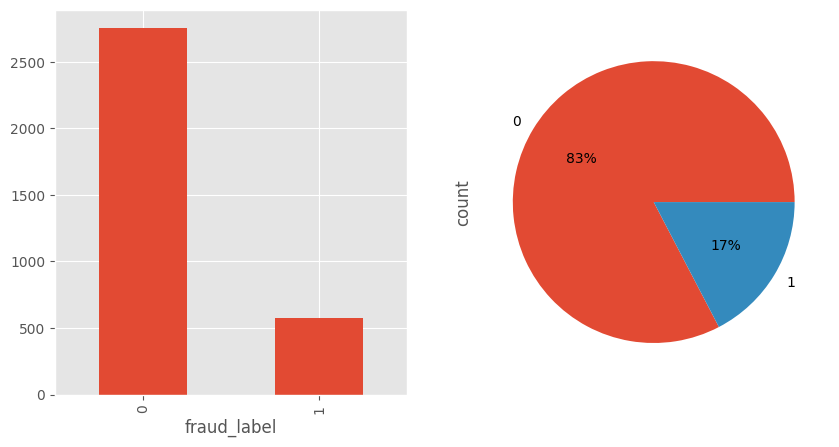

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
df['fraud_label'].value_counts().plot(kind='bar',ax=axs[0])
df['fraud_label'].value_counts().plot(kind='pie', autopct='%.0f%%', ax=axs[1])
plt.show()

### 1.2 Examine Numercial Features

Mình sẽ lấy các numerical features ra

Bạn hãy lưu ý feature most_active_hour (thời gian hoạt động active nhất trong ngày), feature này là 1 category feature chứ không phải là numerical feature nhe

In [8]:
# Get numerical feature columns
numfeat_cols = df.select_dtypes(include=np.number).columns.tolist()
numfeat_cols.remove('customer_id')
if 'fraud_label' in numfeat_cols:
    numfeat_cols.remove('fraud_label')
numfeat_cols.remove('most_active_hour')
len(numfeat_cols),numfeat_cols

(37,
 ['age',
  'customer_points',
  'total_redeemed_points',
  'discount_rate',
  'aov_last_30days',
  'membership_lifespan',
  'num_day_since_last_active',
  'num_active_last_7d',
  'num_active_last_14d',
  'num_active_last_30d',
  'num_apply_lending',
  'num_reject_lending_by_3pt',
  'total_amount_spent',
  'total_amount_spent_last_30d',
  'total_amount_spent_last_60d',
  'total_amount_spent_last_90d',
  'total_amount_spent_last_180d',
  'total_amount_spent_last_365d',
  'total_tax_amount_spent',
  'total_fee_amount_spent',
  'num_completed_txn',
  'num_canceled_txn',
  'num_reject_txn',
  'pct_reject2total_txn',
  'num_refunded_txn',
  'prob_abuse_promotion',
  'num_used_promotion',
  'prob_abnormal_activity',
  'num_select_promotion',
  'num_interest_products',
  'income_spending_ratio',
  'total_tax_amount',
  'monthly_income',
  'total_property_value',
  'monthly_bill_amount',
  'total_annual_bill_amount',
  'num_bill_overdue'])

Xem các thông tin cơ bản

In [9]:
df.describe()

,customer_id,label_datetime,fraud_label,age,customer_points,total_redeemed_points,discount_rate,aov_last_30days,membership_lifespan,num_day_since_last_active,...,prob_abnormal_activity,num_select_promotion,num_interest_products,income_spending_ratio,total_tax_amount,monthly_income,total_property_value,monthly_bill_amount,total_annual_bill_amount,num_bill_overdue
count,3333.000000,3333,3333.000000,2984.000000,2330.000000,3333.000000,3333.000000,3173.000000,2338.000000,3333.000000,...,3206.000000,2333.000000,3333.000000,3333.000000,3.333000e+03,2.983000e+03,3.333000e+03,1.661000e+03,3.333000e+03,3333.000000
mean,7493.146415,2022-01-31 15:32:46.876687616,0.173417,26.322051,265.128755,131.733573,0.039202,50384.975364,517.017109,185.557756,...,0.684663,553.166738,25.586859,0.493555,4.965836e+06,4.601700e+08,1.246295e+09,2.619049e+07,2.997997e+08,14.747375
min,0.000000,2021-01-02 00:00:00,0.000000,10.000000,0.000000,0.000000,0.010000,23.713233,11.000000,1.000000,...,0.010000,1.000000,0.000000,0.000079,1.010000e+05,1.000000e+06,1.000000e+08,1.000000e+05,3.840000e+05,1.000000
25%,3810.000000,2021-07-24 00:00:00,0.000000,19.000000,26.000000,10.000000,0.020000,25471.156374,324.000000,93.000000,...,0.540000,312.000000,13.000000,0.243990,2.472000e+06,1.020000e+08,9.000000e+08,1.350000e+07,1.510800e+08,10.000000
50%,7455.000000,2022-02-06 00:00:00,0.000000,25.000000,112.500000,36.000000,0.030000,50300.996269,540.000000,186.000000,...,0.740000,589.000000,26.000000,0.488781,4.964000e+06,4.670000e+08,1.300000e+09,2.710000e+07,3.007920e+08,16.000000
75%,11214.000000,2022-08-18 00:00:00,0.000000,31.000000,486.000000,197.000000,0.050000,75410.913849,727.750000,279.000000,...,0.890000,811.000000,38.000000,0.742791,7.413000e+06,7.795000e+08,1.700000e+09,3.940000e+07,4.459560e+08,20.000000
max,14990.000000,2022-12-31 00:00:00,1.000000,79.000000,1000.000000,941.000000,0.100000,99880.751805,899.000000,365.000000,...,0.990000,999.000000,50.000000,0.999995,9.998000e+06,9.990000e+08,1.900000e+09,4.990000e+07,5.999400e+08,24.000000
std,4300.583757,NaN,0.378664,10.985339,292.294041,180.794201,0.028298,28611.125173,243.334044,106.340458,...,0.247395,293.293958,14.492165,0.287360,2.861407e+06,3.408963e+08,4.871662e+08,1.457597e+07,1.721619e+08,6.565335


Nhiều feature có range dao động rất lớn ví dụ monthly_income, total_property_value, monthly_bill_amount...

Chúng ta sẽ cần standardize chúng lại nếu ko sẽ xảy ra vấn đề một số **feature bị overweighted** trong quá trình training

Chúng ta sẽ ghi nhớ điểm này để phần feature pipeline (2.2.1) sẽ nói tiếp

Chúng ta sẽ làm kiểm tra feature correlation, đính kèm label vào để xem xu hướng các feature và mối tương quan của chúng

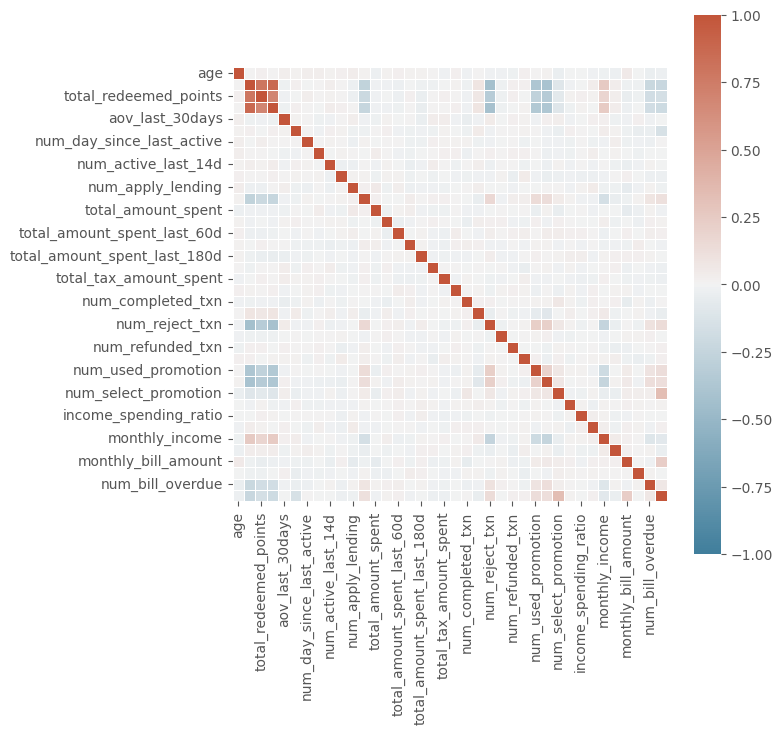

In [10]:
plt.figure(figsize=(7,7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr_maxtrix = df[numfeat_cols + ['fraud_label']].corr()
sns.heatmap(corr_maxtrix, cmap=cmap, center=0, square=True, linewidths=.5, vmin=-1, vmax=1, fmt=".2f")
plt.show()

Rõ ràng thì có 1 cụm feature có mối tương quan cao ở góc trái. Những feature có tương quan cao sẽ có khả năng đi cùng nhau về mặt tác động của nó với label (nghĩa là nếu 1 trong 3 feature có tác động mạnh vào label thì cả 3 sẽ tác động theo và ngược lại)


Còn đối với label thì hầu như ko có feature nào có tương quan với nó cả

### 1.3 Examine Category Features

Chúng ta sẽ kiểm tra category feature

In [11]:
# Get category feature columns + most_active_hour
catfeat_cols = df.select_dtypes(include=['object', bool]).columns.tolist() + ['most_active_hour']
if 'fraud_label' in numfeat_cols:
    catfeat_cols.remove('fraud_label')
len(catfeat_cols), catfeat_cols

(22,
 ['gender',
  'city',
  'occupation',
  'education',
  'marital_status',
  'membership_level',
  'has_fraud_txn',
  'has_used_jailbreak',
  'is_emulator',
  'is_blacklist',
  'signup_in_latenight',
  'top_rejected_reason',
  'top_refunded_reason',
  'top_payment_method',
  'top_payment_channel',
  'is_ordering_shipping_address_same',
  'income_stability',
  'income_source',
  'annually_income_segment',
  'top_property_type',
  'in_debt',
  'most_active_hour'])

Check unique values of each category features

In [12]:
df[catfeat_cols].nunique()

gender                                3
city                                 62
occupation                           22
education                             7
marital_status                        7
membership_level                      3
has_fraud_txn                         2
has_used_jailbreak                    2
is_emulator                           2
is_blacklist                          2
signup_in_latenight                   2
top_rejected_reason                   7
top_refunded_reason                   8
top_payment_method                    5
top_payment_channel                   5
is_ordering_shipping_address_same     2
income_stability                      4
income_source                         6
annually_income_segment               4
top_property_type                     4
in_debt                               2
most_active_hour                     24
dtype: int64

Bạn hãy để ý nếu các category feature nào có quá nhiều unique value thì sẽ gây ra 1 tình trạng gọi là **sparse matrix**

Để hiểu rõ hơn thì các category feature khi chuyển thành feature xài được thì được encode lại thành dạng One-Hot Vector. 

**One Hot Vector là gì?**

Là chuyển đổi từ 1 category columns thành k columns (với k là số lượng unique value trong column đó)

- Ví column gender có 3 giá trị [Nam, Nữ, Khác]. Khi đó one-hot-vector của gender là [0, 0, 1] với 1 sẽ là vị trí của giá trị đó

- Giả sử customer_id 1 là Nam thì giá trị one-hot-encoder của gender là [1, 0, 0] ứng với  [Nam, Nữ, Khác]

- Điều này cũng đồng nghĩa nếu giả sử cột city có 62 tỉnh thành thì sẽ là 1 vector 62 chiều. 

- Và khi nói đến city_matrix của toàn data sẽ là 1 vector toàn số 0 và rất ít số 1, gọi là **sparse matrix**

**Sparse matrix** gây ra tình trạng 

  - Chiếm bộ nhớ quá nhiều trong tính toán
  - Gây overfit cho model (đây là 1 trade-off, tuy nhiên theo mình thì dưới 100 vẫn xài được)

  
> Đối với trường hợp, sau này gender có thêm giá trị null thì One-Hot-Encoder (thư viện để chuyển đổi One-Hot-Vector của sklearn) sẽ treat null như là 1 giá trị riêng. Tương đương là vector 4 chiều [Nam, Nữ, Khác, null]

> Boolean: cũng là category feature nhé, và bạn cần cẩn thận với feature này. 

> most_active_hour tuy là dạng số nhưng về mặt data logic thì nó là category features.

**Làm sao để phân biệt category feature mà nó là *format number*:**

- Bạn hiểu rằng numberical feature có xu hướng linear, trong khi category feature có dạng non-linear transformation

  - Ví dụ linear, age có xu hướng đi từ 1 lên 65 và cao hơn

  - Ví dụ non-linear, hour trong ngày từ 1 có thể lên 23 nhưng từ 23 về 1 lại là 1 non-linear transformation (là 1 periodic cyclic)
  
  - Đặc biệt: feature dạng time/day/periodic cycle có thể treat bằng category hoặc [time-related feature engineering](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html)

## 2. Data Pipeline

### 2.1 Train/Test selection

Đầu tiên chúng ta sẽ xem label theo tháng ra sao

- Đa phần label ở các tháng đều tương đồng, duy nhất có rất nhiều label ở tháng 2022-12

<Axes: xlabel='label_datetime'>

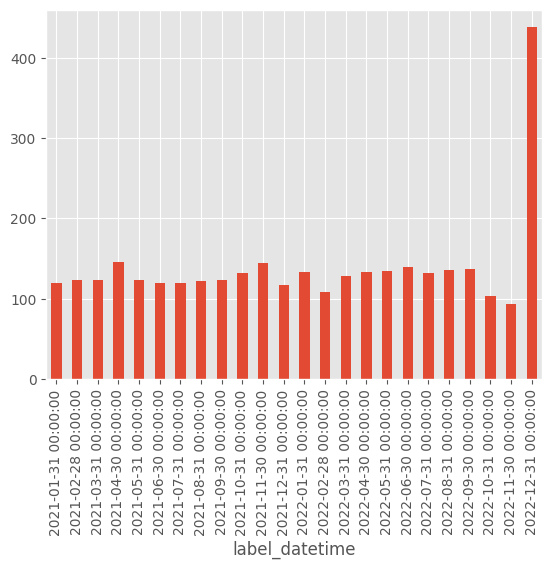

In [13]:
df.set_index('label_datetime')['customer_id'].resample('1M').nunique().plot(kind='bar')

In [14]:
# Split theo đề bài, bạn lấy mốc 2022-10 trở về trước làm train và data sau 2022-10 là test

selected_date = '2022-10-01'
train_data = df[df['label_datetime'] < selected_date]
test_data = df[df['label_datetime'] >= selected_date]

# No sample is ignored
train_data.shape, test_data.shape

((2698, 62), (635, 62))

Train and test dataset size is 81:19

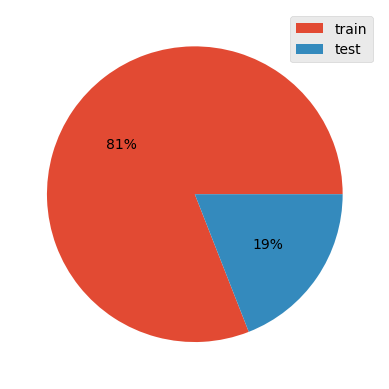

In [15]:
plt.figure()
plt.pie(x=[train_data.shape[0], test_data.shape[0]], autopct='%.0f%%')
plt.legend(['train','test'])
plt.show()

### 2.2 Feature Transformation

Chúng ta sẽ đi qua phần feature transformation

#### 2.2.1 Feature Pipeline

In [16]:
# all feat cols
feat_cols = numfeat_cols + catfeat_cols
len(feat_cols), feat_cols

(59,
 ['age',
  'customer_points',
  'total_redeemed_points',
  'discount_rate',
  'aov_last_30days',
  'membership_lifespan',
  'num_day_since_last_active',
  'num_active_last_7d',
  'num_active_last_14d',
  'num_active_last_30d',
  'num_apply_lending',
  'num_reject_lending_by_3pt',
  'total_amount_spent',
  'total_amount_spent_last_30d',
  'total_amount_spent_last_60d',
  'total_amount_spent_last_90d',
  'total_amount_spent_last_180d',
  'total_amount_spent_last_365d',
  'total_tax_amount_spent',
  'total_fee_amount_spent',
  'num_completed_txn',
  'num_canceled_txn',
  'num_reject_txn',
  'pct_reject2total_txn',
  'num_refunded_txn',
  'prob_abuse_promotion',
  'num_used_promotion',
  'prob_abnormal_activity',
  'num_select_promotion',
  'num_interest_products',
  'income_spending_ratio',
  'total_tax_amount',
  'monthly_income',
  'total_property_value',
  'monthly_bill_amount',
  'total_annual_bill_amount',
  'num_bill_overdue',
  'gender',
  'city',
  'occupation',
  'education'

Để có thể đối phó với các giá trị null và các numerical feature mà phân phối nó quá rộng, chúng ta sẽ sử dụng quick-solve

- SimpleImputer: để fill các giá trị null bằng giá trị median/mean/min/max/q25...

- StandardScaler: để standardize các numerical feature mà range nó quá rộng


Mình sử dụng Pipeline của sklearn để thiết kế cái khung trước

In [17]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

Với category features, như mình đã nói ở trên, bạn sử dụng OneHotEncoder và handle những giá trị chưa từng biết bằng cách treat những giá trị đó là vector zeros

Tham khảo thêm: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [18]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

Tạo feature pipeline với num và cat, hình vẽ minh họa ở dưới

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numfeat_cols),
        ("cat", categorical_transformer, catfeat_cols),
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'customer_points',
                                  'total_redeemed_points', 'discount_rate',
                                  'aov_last_30days', 'membership_lifespan',
                                  'num_day_since_last_active',
                                  'num_active_last_7d', 'num_active_last_14d',
                                  'num_active_last_30d', 'num_apply_lending',
                                  'n...
                                  'marital_status', 'membership_level',
                                  'has_fraud_txn', 'has_used_jailbreak',
                                  'is_emulator', 'is_blacklist',
                                  'signup_in_latenight', 'top_rejected_reason',
                                  'top_refunded_reason', 'top_payment_method',
                                  'top_payment_channel',
                                  'is_ordering_shipping_address_same',
                                  'income_stability', 'income_source',
                                  'annually_income_segment',
                                  'top_property_type', 'in_debt',
                                  'most_active_hour'])])

#### 2.2.2 X,y of train & test

In [20]:
X_train, y_train = train_data[feat_cols], train_data['fraud_label']
X_train.shape, y_train.shape

((2698, 59), (2698,))

In [21]:
X_test, y_test = test_data[feat_cols], test_data['fraud_label']
X_test.shape, y_test.shape

((635, 59), (635,))

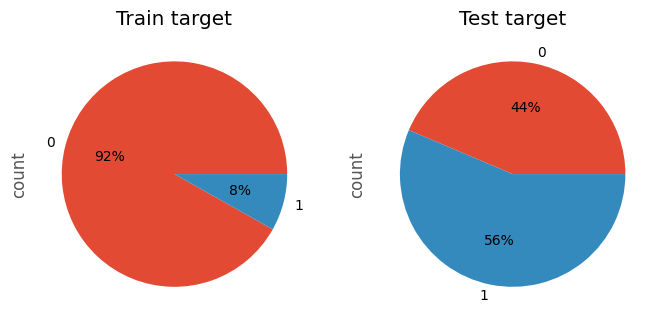

In [22]:
# Check label distribution of each dataset
fig, axs = plt.subplots(1,2, figsize=(8,5))
y_train.value_counts().sort_index().plot(kind='pie', autopct='%.0f%%',ax=axs[0], title='Train target',)
y_test.value_counts().sort_index().plot(kind='pie', autopct='%.0f%%',ax=axs[1], title='Test target')
plt.show()

Ở đây test set rất khác biệt khi lượng lớn fraud tập trung ở test, trong khi ở train, thì chỉ có 8% là fraud

Tình huống này cũng dễ gặp, khi càng gần tới mùa promotion các fraud sẽ nổi lên

#### 2.2.2 Feature Transform

In [23]:
# fit, transform, fit_transform

In [24]:
# fit columns-transformer với feature 
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'customer_points',
                                  'total_redeemed_points', 'discount_rate',
                                  'aov_last_30days', 'membership_lifespan',
                                  'num_day_since_last_active',
                                  'num_active_last_7d', 'num_active_last_14d',
                                  'num_active_last_30d', 'num_apply_lending',
                                  'n...
                                  'marital_status', 'membership_level',
                                  'has_fraud_txn', 'has_used_jailbreak',
                                  'is_emulator', 'is_blacklist',
                                  'signup_in_latenight', 'top_rejected_reason',
                                  'top_refunded_reason', 'top_payment_method',
                                  'top_payment_channel',
                                  'is_ordering_shipping_address_same',
                                  'income_stability', 'income_source',
                                  'annually_income_segment',
                                  'top_property_type', 'in_debt',
                                  'most_active_hour'])])

Chuyển đổi data ban đầu sang thành transformed data

In [25]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Get new transformed feature names

In [26]:
transfeat_cols = preprocessor.get_feature_names_out()
transfeat_cols.shape, transfeat_cols

((227,),
 array(['num__age', 'num__customer_points', 'num__total_redeemed_points',
        'num__discount_rate', 'num__aov_last_30days',
        'num__membership_lifespan', 'num__num_day_since_last_active',
        'num__num_active_last_7d', 'num__num_active_last_14d',
        'num__num_active_last_30d', 'num__num_apply_lending',
        'num__num_reject_lending_by_3pt', 'num__total_amount_spent',
        'num__total_amount_spent_last_30d',
        'num__total_amount_spent_last_60d',
        'num__total_amount_spent_last_90d',
        'num__total_amount_spent_last_180d',
        'num__total_amount_spent_last_365d', 'num__total_tax_amount_spent',
        'num__total_fee_amount_spent', 'num__num_completed_txn',
        'num__num_canceled_txn', 'num__num_reject_txn',
        'num__pct_reject2total_txn', 'num__num_refunded_txn',
        'num__prob_abuse_promotion', 'num__num_used_promotion',
        'num__prob_abnormal_activity', 'num__num_select_promotion',
        'num__num_interest_prod

Các bạn sẽ thấy có tận 227 columns so với 59 columns ban đầu, lý do là OneHotEncoder đã sinh ra rất nhiều column mới

- Prefix **num__** for numerical features (which is exactly 37 cols)

- Prefix **cat__** for category features following with suffix **_{value}** of each unique value of each feature

  - suffix **_nan** indicate that OneHotEncoder treat null value as a separate value of that category feature
  
  - example: cat__gender_Khác là 1 vector one-hot thuộc gender có giá trị *Khác*

In [27]:
X_train_transformed.shape, X_test_transformed.shape

((2698, 227), (635, 227))

The number of origin features is 59 and now transformed features is 227

**Simple Imputer**

Simple Imputer gây biến đổi với dữ liệu origin, hãy cẩn thận với columns có quá nhiều null

In [28]:
np.where(transfeat_cols=='num__monthly_income')

(array([32]),)

In [29]:
X_train['monthly_income'].isna().sum() / len(X_train['monthly_income'])

0.09970348406226835

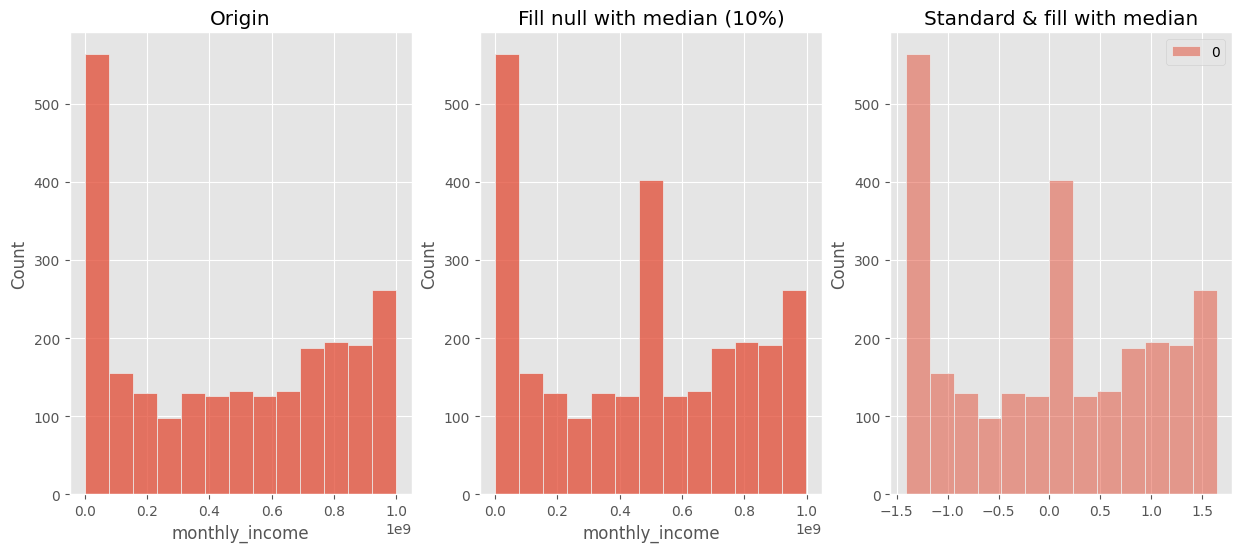

In [30]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
sns.histplot(X_train['monthly_income'],ax=axs[0])
axs[0].set_title('Origin')
median_monthly_income = X_train['monthly_income'].median()
sns.histplot(X_train['monthly_income'].fillna(median_monthly_income),ax=axs[1])
axs[1].set_title('Fill null with median (10%)')
sns.histplot(X_train_transformed[:, 32].toarray(),ax=axs[2])
axs[2].set_title('Standard & fill with median')
plt.show()

### 2.2 Train Pipeline

#### Logistic Regression
**Giới thiệu:** Logistic Regression là một thuật toán phân loại dựa trên hồi quy, nó ước tính xác suất của một điểm dữ liệu thuộc lớp tích cực (positive class).

**Ưu điểm:**
- Dễ dàng hiểu và giải thích.
- Phù hợp cho các bài toán có dữ liệu tương đối đơn giản và tách biệt tuyến tính.

**Nhược điểm:**
- Khả năng xử lý dữ liệu phức tạp và tách biệt phi tuyến tính kém.
- Dễ bị ảnh hưởng bởi nhiễu và dữ liệu ngoại lai.
- Có thể cần một số công việc tiền xử lý dữ liệu để phù hợp.

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
models = [
    ('Logistic Regression', LogisticRegression()),
]

In [33]:
# Dict to store result of each model
results = {i[0]:{} for i in models}
results

{'Logistic Regression': {}}

#### Model training

In [34]:
from datetime import datetime

In [35]:
for name, model in models:
    start = datetime.now()
    model.fit(X_train_transformed, y_train)
    print(name, datetime.now() - start)
    results[name]['y_train_pred'] = model.predict(X_train_transformed)
    results[name]['y_train_prob'] = model.predict_proba(X_train_transformed)
    results[name]['y_test_pred'] = model.predict(X_test_transformed)
    results[name]['y_test_prob'] = model.predict_proba(X_test_transformed)

Logistic Regression 0:00:00.032718


/Users/quan/opt/miniconda3/envs/aicv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3. Logistic Regression Evaluation

Ở bài trước chúng ta đã được học Precision và Recall và hiểu tại sao Accuracy ko hữu hiệu trong bài toán imbalanced dataset

In [36]:
from sklearn import metrics

In [37]:
metric_records = {i[0]:{} for i in models}
metric_records

{'Logistic Regression': {}}

### AUCROC, AUCPR, Distribution & Confusion Matrix

In [38]:
def evalute_performance(name,model):
    def evaluate_dataset(dataset):
        print(f'Evaluate {dataset} set')
        
        y_pred = results[name][f'y_{dataset}_pred']
        y_prob = results[name][f'y_{dataset}_prob']
        y_score = y_prob[:,1] # prob of positive label
        
        if dataset == 'train':
            y_true = y_train
        else:
            y_true = y_test
        
        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
        auc_score = metrics.auc(fpr, tpr)
        print('\tAUC', auc_score)

        # ROC
        fig,axs=plt.subplots(1,3,figsize=(15,5))
        metrics.RocCurveDisplay.from_predictions(y_true, y_score, name=name, plot_chance_level=True,ax=axs[0],)
        axs[0].title.set_text('ROC binary classifibcation')

        # PRC
        metrics.PrecisionRecallDisplay.from_predictions(y_true, y_score, name=name, plot_chance_level=True, ax=axs[1],)
        axs[1].set_title("Precision-Recall curve")
        axs[1].legend(loc='best')

        # PDF
        sns.histplot(y_prob,ax=axs[2], kde=True, stat='density', common_norm=True, bins=10)
        axs[2].set_title("Probility Distribution of Label")
        plt.show()
        
        # Confusion matrix
        metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
        plt.show()

        # classification matrix
        print('Classification Report with default threshold=0.5')
        print(metrics.classification_report(y_true, y_pred))
        p,r,f, _ = metrics.precision_recall_fscore_support(y_true, y_pred, average='binary', )
        
        metric_records[name][f'{dataset}_auc'] = auc_score
        metric_records[name][f'{dataset}_precision'] = p
        metric_records[name][f'{dataset}_recall'] = r
        metric_records[name][f'{dataset}_f1'] = f
        
    print('======================')
    print(f'Performance of {name}\n')
    evaluate_dataset('train')
    evaluate_dataset('test')
    print('\n\n')

Performance of Logistic Regression

Evaluate train set
	AUC 0.9142105070071171


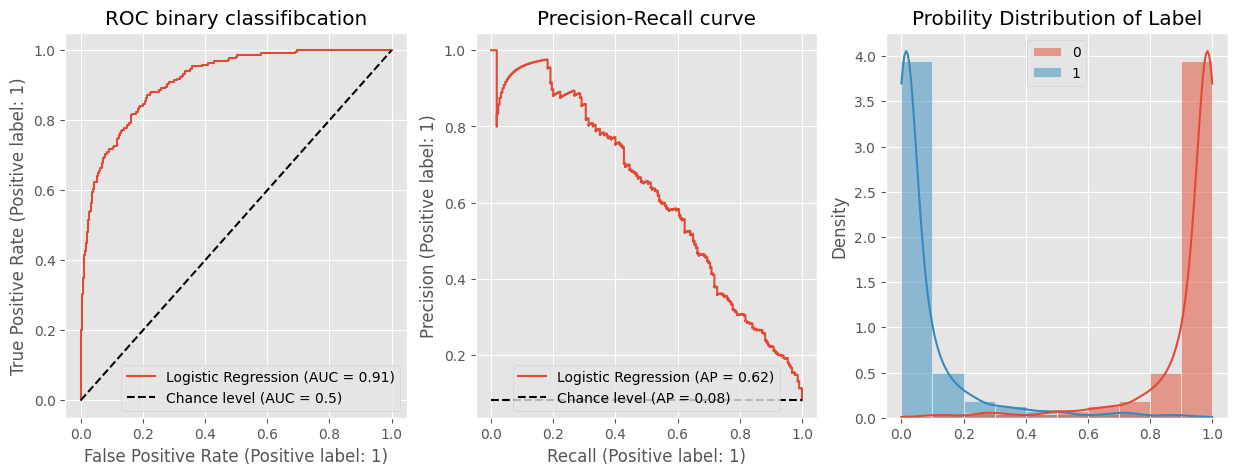

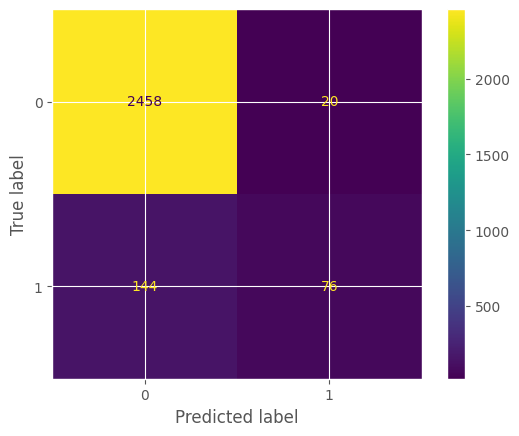

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2478
           1       0.79      0.35      0.48       220

    accuracy                           0.94      2698
   macro avg       0.87      0.67      0.72      2698
weighted avg       0.93      0.94      0.93      2698

Evaluate test set
	AUC 0.8379989109170481


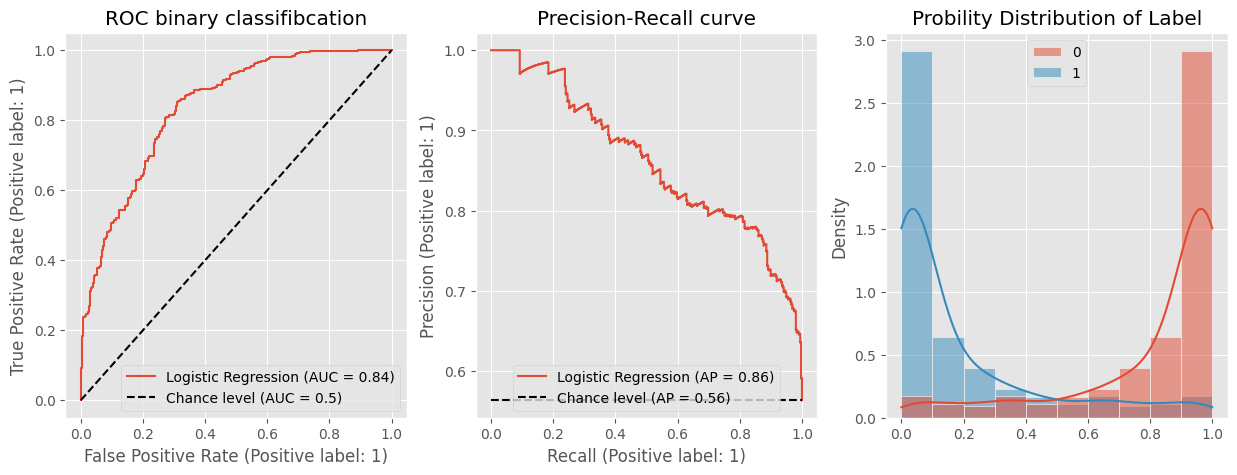

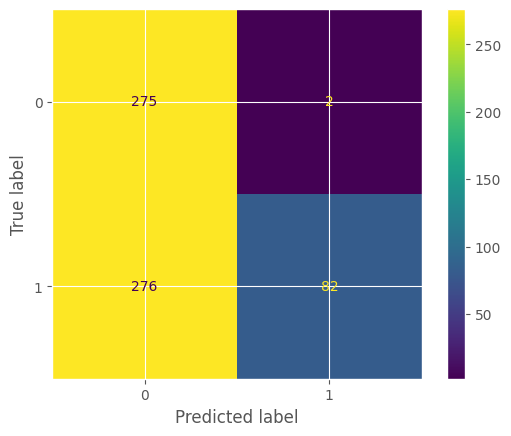

Classification Report with default threshold=0.5
              precision    recall  f1-score   support

           0       0.50      0.99      0.66       277
           1       0.98      0.23      0.37       358

    accuracy                           0.56       635
   macro avg       0.74      0.61      0.52       635
weighted avg       0.77      0.56      0.50       635






In [39]:
name, model = models[0]
evalute_performance(name, model)

Chúng ta sẽ stick với Logistic Regression Model và tìm hiểu nó sâu vào

## 4. Understand Coefficients

Ok chúng ta sẽ dùng coefficients của Logistic Regression để giải thích ý nghĩa của nó

Dưới đây là bảng coefficient của Logistic Regression model, (coeff có thể là âm hoặc dương)

In [40]:
coeff_df = pd.Series(model.coef_.ravel(), index=transfeat_cols).sort_values()

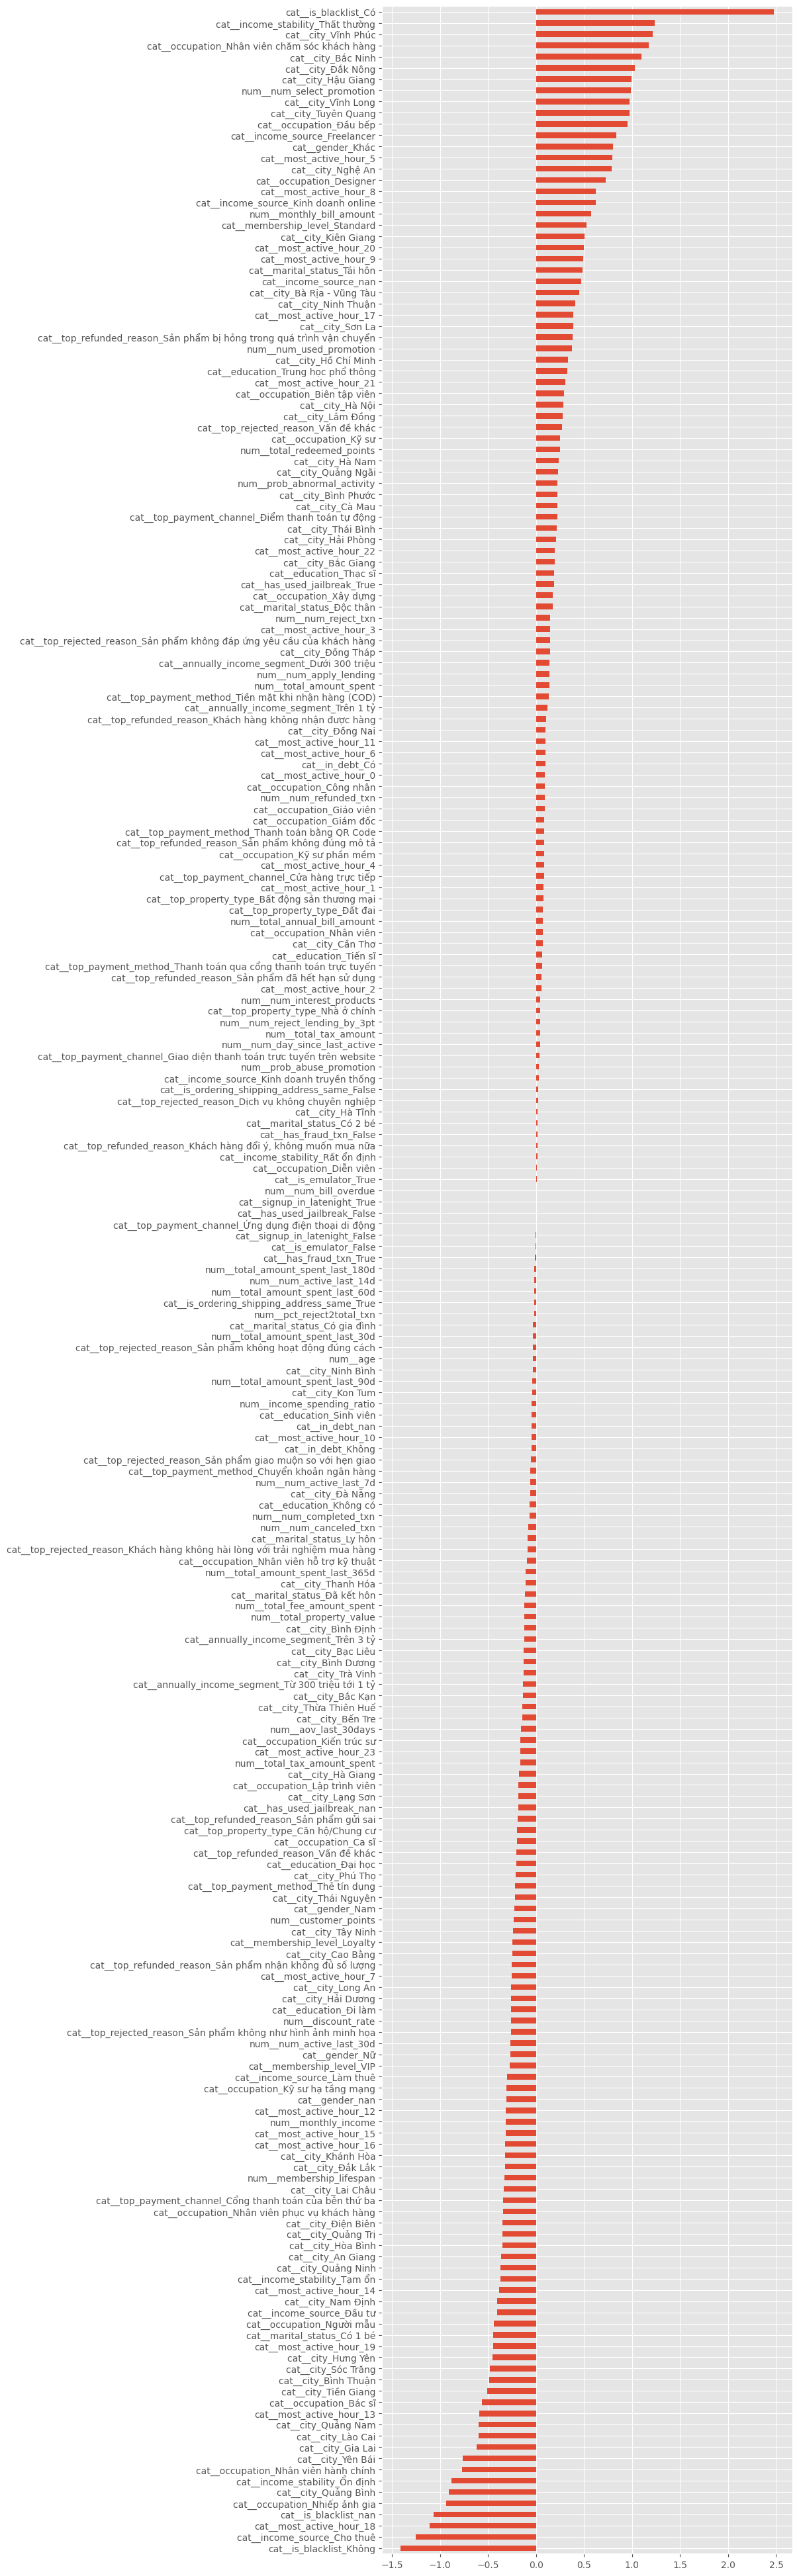

In [41]:
coeff_df.plot.barh(figsize=(8,50))
plt.show()

Bạn có thể tham khảo thêm ý nghĩa của Coefficients

**References**
- https://towardsdatascience.com/a-simple-interpretation-of-logistic-regression-coefficients-e3a40a62e8cf
- https://www.statology.org/interpret-logistic-regression-intercept/
- https://www.statology.org/interpret-logistic-regression-coefficients/

### 4.1 Giải thích Logistic Regression

- Lý thuyết: Logistic Regression là 1 mô hình hồi quy, mô hình hóa xác suất vào sự quyết định lựa chọn của model (logit model). Logit function sử dụng phương pháp Maximum likelihood estimation. Logistic Regression hay còn gọi là logit model

<img src="./static/logit.jpeg" style="width: 800px;"/>

**Ý tưởng cho Logit function**

Ý tưởng được đưa ra dựa trên Linear Regression, chúng ta đều biết linear regression có dạng

<center> LinearReg = $\hat{y} = f(x) = \beta_{0} + \beta_{1}x_{1} + ... +  \beta_{n}x_{n}$ </center>
    
cho chúng ta kết quả 1 continuous output

Trong đó: 

- $\hat{y}$: là phương trình dự đoán của hàm linear regression
- $\beta_{1}, \beta_{2}, ..., \beta_{n}$ là các hệ số trong phương trình (tương ứng với weight)
- $x_{1}, x_{2}, ..., x_{n}$ là các  feature data (ví dụ như income, age, monthly_bill...)

**Constraint**
- Linear Regression là tìm kiếm 1 phương trình đường thẳng fit tốt nhất (tương ứng giảm error) nhỏ nhất

**Hàm loss của Linear Regression**

Chúng ta đều biết loss của Linear Regression là Mean-Square-Error (MSE)

<center>$MSE=\frac{1}{N}\sum_{i=1}^{n}{(y_{i}-\hat{y}_{i})^{2}}$</center>

và chúng ta tối ưu mô hình bằng cách minimize MSE

Sau khi tối ưu thì chúng ta sẽ tìm được hệ số phương trình đường thẳng, hệ số này biểu diễn sự mạnh yếu mỗi feature

**Với trực giác trên**

Mục tiêu của logit model là intro các parameters cùng hệ số như trên vào phương trình, để có thể giải thích được độ mạnh yếu (weighted coefficients) của từng feature data. Để làm sao mà:

<center>LogReg = $logitfunc = \beta_{0} + \beta_{1}x_{1}+ \beta_{2}x_{2} + ... + \beta_{n}x_{n}$</center>

Ok, ta đã biết ý tưởng đưa tính chất linear regression vào logistic regression.

Giờ chúng ta làm sao biểu diễn LogReg theo dạng tỷ lệ xác suất, vì bài toán chỉ có 0 và 1 nên ta có thể làm điều này

Trước hết chúng ta sẽ tìm hiểu tỷ lệ cược

**Định nghĩa Odd (Tỉ lệ cược)**

https://towardsdatascience.com/a-simple-interpretation-of-logistic-regression-coefficients-e3a40a62e8cf

Gọi 

- $p \quad\quad\quad$ là tỷ lệ fraud (hoặc thắng cược trong chơi bài, hoặc 1 sự kiện diễn ra)
- $1 - p \quad$ là tỷ lệ non-fraud (hoặc thua )

Giả sử:
- tỉ lệ quay ra số 1 của xúc sắc là 1/6 = 16.6%
- suy ra, tỉ lệ ko quay ra số 1 là 5/6 = 83.3%

Thì 

- $\frac{p}{1-p}$ còn gọi là **odd ratio**, 

- $logit(p) = ln(\frac{p}{1-p})$ là **log of the odds** hay còn gọi là **logit** 

Suy ra:
- tỉ lệ odd của quay ra số 1 của xúc sắc là $\frac{1/6}{5/6}=\frac{1}{5}=0.2$ = 20%

đây gọi là tỉ lệ odd hoặc tỷ lệ thắng/thua, tỉ lệ cược

### 4.2 Phương trình logit

Ta cho **log of the odds** bằng với phương trình tương tự như linear regression (đã lý giải ở trên)

<center>LogReg = $logit(p) = ln(\frac{p}{1-p}) = \beta_{0} + \beta_{1}x_{1}+ \beta_{2}x_{2} + ... + \beta_{n}x_{n}$</center>

trong đó:

- $\beta_{0}$: là intercept

- $x_{j}$: là các feature data

- $\beta_{j}$: là coefficient của feature data

Ta có thể tính được $p$ (tỉ lệ fraud) theo toán, bạn có thể tự giải được (gợi ý $ln(x) = y$ thì $x = e^{y}$)

<center>$p =\frac{e^{logit}}{1+e^{logit}}= \frac{1}{1+e^{-logit}} = \frac{e^{β_{0} + β_{1}x_{1} + β_{2}x_{2} + … + β_{p}x_{p}}}{(1 + e^{β_{0} + β_{1}x_{1} + β_{2}x_{2} + … + β_{n}x_{n}})}$</center>

**Đồ thị hàm $\frac{e^{logit}}{1+e^{logit}}$**

Ta có thể thấy hàm $\frac{e^{logit}}{1 + e^{logit}}$ có limit = 0 hoặc 1 (với -inf và +inf). Đây là 1 tính chất rất đẹp và phù hợp để biểu diễn xác suất

Trong đó: $logit = \beta_{0} + \beta_{1}x_{1} + ... +  \beta_{n}x_{n}$

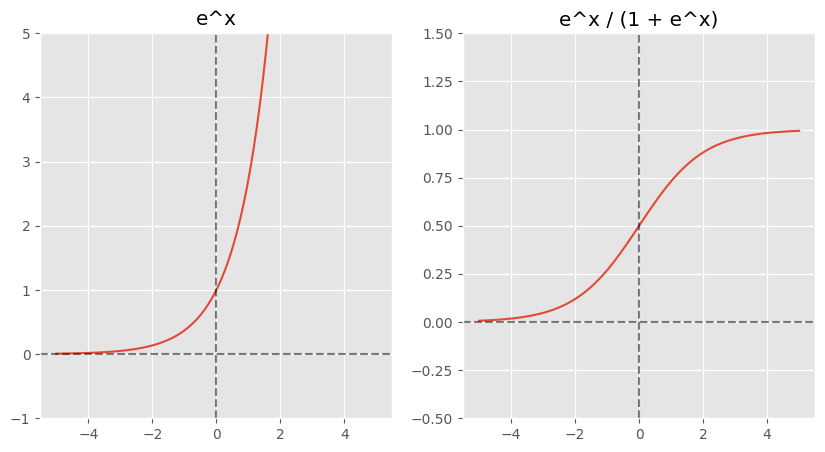

In [42]:
x = np.linspace(-5, 5, 100)
y = np.e**(x)
fig, axs = plt.subplots(1,2, figsize=(10,5))
# e^z
axs[0].set_title('e^x')
axs[0].plot(x,y)
axs[0].axvline(x = 0, linestyle='--', color='black', alpha=0.5)
axs[0].axhline(y = 0, linestyle='--', color='black', alpha=0.5)
axs[0].set_ylim (-1, 5)
# e^z/(1+e^z)
y1 = np.e**(x) / (1 + np.e**(x))
axs[1].set_title('e^x / (1 + e^x)')
axs[1].plot(x,y1)
axs[1].axvline(x = 0, linestyle='--', color='black', alpha=0.5)
axs[1].axhline(y = 0, linestyle='--', color='black', alpha=0.5)
axs[1].set_ylim (-0.5, 1.5)
plt.show()

Bạn theo kịp chứ?

Giờ chúng ta sẽ làm ví dụ cho bài toán này

### 4.3 Áp dụng LogReg coefficients

Chúng ta có được hệ số từ model, có tới 227 feature trong đây

In [43]:
coeff_df

cat__is_blacklist_Không                         -1.408359
cat__income_source_Cho thuê                     -1.252518
cat__most_active_hour_18                        -1.104849
cat__is_blacklist_nan                           -1.067383
cat__occupation_Nhiếp ảnh gia                   -0.936457
                                                   ...   
cat__city_Bắc Ninh                               1.097475
cat__occupation_Nhân viên chăm sóc khách hàng    1.172115
cat__city_Vĩnh Phúc                              1.217153
cat__income_stability_Thất thường                1.237078
cat__is_blacklist_Có                             2.476409
Length: 227, dtype: float64

Để lấy intercept

In [44]:
b0 = model.intercept_
b0

array([-2.46569599])

Để làm ví dụ mẫu, mình sẽ lấy ra 4 feature 2 cat và 2 num, mỗi loại có coeff âm và dương

cat__is_blacklist_Có           2.476409
num__num_select_promotion      0.990733
cat__income_source_Cho thuê   -1.252518
num__membership_lifespan      -0.329927
dtype: float64

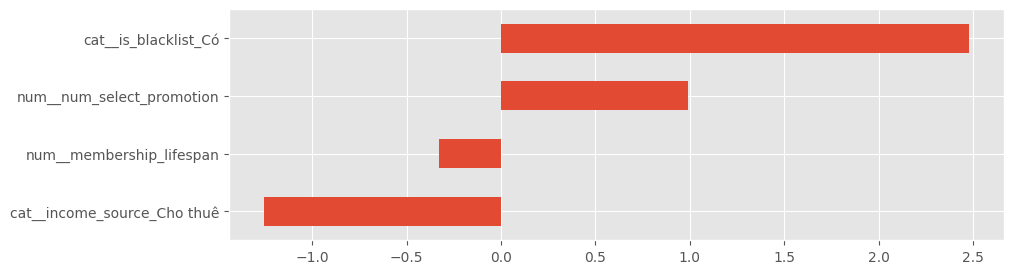

In [45]:
sel_coef = coeff_df.sort_values()[::-1].iloc[[0,7, 225, 193]]
display(sel_coef)
sel_coef.sort_values().plot.barh(figsize=(10, 3))
plt.show()

> **Lưu ý**: để tóm tắt ngắn gọn lại thì phần giải thích sau chỉ mang tính minh họa không phải con số tính toán thực tế. Thực tế chúng ta có tới 227 features nên công thức chính xác phải được gom tương ứng nhiêu đó

Ứng với trên chúng ta cho:

1. $\beta_{0}$ là intercept
1. $\beta_{1} ,x_{1}$ là hệ số và biến cat__is_blacklist
1. $\beta_{2} ,x_{2}$ là hệ số và biến num_select_promotion
1. $\beta_{3} ,x_{3}$ là hệ số và biến cat__income_source_Cho Thuê
1. $\beta_{4} ,x_{4}$ là hệ số và biến num_membership_lifespan

Ta có

1. $\beta_{0}$ = -2.5
1. $\beta_{1}$ = 2.5
1. $\beta_{2}$ = 1
1. $\beta_{3}$ = -1.3
1. $\beta_{4}$ = -0.3

Cho nên: LogReg = $logit(p) = -2.5 + 2.5x_{1} + x_{2} - 1.3x_{3} - 0.3x_{4}$

**Giải thích tác động của Intercept**

Giả sử tất cả các biến $x_{i}$ bằng 0 (chỉ $\beta_{0}$ is present), then $p = \frac{e^{logit}}{1 + e^{logit}} = \frac{e^{\beta_{0}}}{1 + e^{\beta_{0}}}$

Nghĩa là khi tất cả các feature data đều bằng 0, **log odds** của fraud-user này là -2.5

In term of probability:

- Probability of fraud = $\frac{e^{\beta_{0}}}{1 + e^{\beta_{0}}}$
- Probability of fraud = $\frac{e^{-2.5}}{1 + e^{-2.5}}$
- Probability of fraud = 0.08 (8%)

Tức là với tình huống và điều kiện thông thường (ko có tác nhân nào), model cho chúng ta 8% tỷ lệ fraud. Một cách nói khác, mọi user đều có 8% là fraud ở điều kiện thông thường

**Giải thích tác động của Coefficient**

Tương tự như intercept, nhưng lần này chúng ta sẽ cho intercept và các feature khác = 0 (ngoại trừ 4 feature mà ta đang xem xét)

<details>
    <summary>Giả định thống kê (mình sẽ ko cover vì phần này tương đối khó hiểu và dài)
    </summary>
    
        Khi làm việc với regression analysis, sẽ liên quan tới 1 số thống kê, để vắn tắt mình sẽ giả định như sau
    
        p_values của tất cả feature < 0.05, nghĩa là nó statistically significant effect lên sự quyết định cuối cùng 
                                           
        Hay nói khác, mọi sự thay đổi giá trị của feature đều chứng thực có thay đổi theo lý thuyết thống kê (vì có những trường hợp nếu lý thuyết thống kê bác bỏ thì sự thay đổi giá trị của feature đó ko đủ chứng cứ để xác nhận sự thay đổi)
</details>

**Category Feature (one-hot only)**

Chúng ta sẽ giải thích 2 category feature là **is_blacklist, income_source_Cho Thuê**

1. is_blacklist (Yes or No)

$\beta_{1} = 2.5$ (assume that p_value < 0.05) means that, **odd ratio** = $\frac{p}{1-p}=\frac{fraud}{nonfraud}=e^{2.5} = 12.2$

Chúng ta giải thích rằng những user có feature *is_blacklist=1*. 

- Có 12.2 lần tỷ lệ fraud so với những users có *is_blacklist=0* (giả sử rằng tất cả các feature khác đều giữ nguyên)
- $p = \frac{e^{logit}}{1+e^{logit}} = \frac{12.2}{1+12.2}$=92.4%, tỷ lệ fraud nếu feature này bằng Yes/True/1

2. income_source_Cho Thuê (income source từ cho thuê hay ko Yes/No)

$\beta_{3} = -1.3$ => $e^{-1.3} = 0.27$

Chúng ta giải thích rằng những user có feature *income_source_Cho Thuê=1*. 

- Có 0.27 lần tỷ lệ fraud so với những users có *income_source_Cho Thuê=0* (giả sử rằng tất cả các feature khác đều giữ nguyên)

- $p = \frac{1}{1+e^{-logit}} = \frac{0.27}{1+0.27}$=21.3% tỷ lệ fraud nếu feature này bằng Yes/True/1 

- Hoặc những user có income từ cho thuê có tỷ lệ (1 - 0.27) = 72.7% thấp hơn tỷ lệ fraud so với những user không có income từ nguồn cho thuê

**Continuous Feature**

1. num_select_promotion (số lượng promotion được lấy của user đó)

$\beta_{2} = 1 => e = 2.72$

- Chúng ta thấy coeff của num_select_promotion là dương, nghĩa là với mỗi số lượng tăng thêm của promotion sẽ tăng lên xác suất user ấy là fraud lên 2.72 lần

- Hoặc với mỗi số lượng promotion được select thêm sẽ tăng (2.72 - 1) = 172% xác suất user ấy là fraud (với tất cả các biến khác được giả sử là giữ nguyên)

- $p = \frac{1}{1+e^{-logit}} = \frac{1}{1+e^{-1}}$=73.1% xác suất là fraud với promotion tăng từ 0 lên 1

- $p = \frac{1}{1+e^{-logit}} = \frac{1}{1+e^{-2}}$=88.1% xác suất là fraud với promotion tăng từ 0 lên 2

  - 88.1 - 73.1 = 14.9% xác suất tăng lên là fraud với promotion tăng từ 1 lên 2

- $p = \frac{1}{1+e^{-logit}} = \frac{1}{1+e^{-3}}$=95.3% xác suất là fraud với promotion tăng từ 0 lên 3

Đây là cách continous data được giải thích với Logistic Regression coefficient

2. membership_lifespan (thời gian làm membership)


$\beta_{4} = -0.3 => e^{-0.3} = 0.74$

- Chúng ta thấy coeff của membership_lifespan là âm, nghĩa là với mỗi ngày làm member lâu hơn sẽ giảm xác suất user ấy là fraud xuống (1 - 0.74) 26% 

- $p = \frac{1}{1+e^{-logit}} = \frac{1}{1+e^{-(-0.3*1)}}$=42.6% xác suất là fraud với số ngày membership tăng từ 0 lên 1

- $p = \frac{1}{1+e^{-logit}} = \frac{1}{1+e^{-(-0.3*2)}}$=35.4% xác suất là fraud với số ngày membership tăng từ 0 lên 2

  - 42.6 - 35.4 = 7% xác suất giảm xuống là fraud với số ngày membership tăng từ 1 lên 2

- $p = \frac{1}{1+e^{-logit}} = \frac{1}{1+e^{-(-0.3*3)}}$=28.9% xác suất là fraud với số ngày membership tăng từ 0 lên 3

> Nếu bạn chưa hiểu: không sao cả, hãy note ở lại đây vì cái cách chúng ta hiểu về log-odd tương đối khó hiểu hơn so với cách hệ số phương trình đường thẳng giải thích. Các bạn có thể xem lại sau rồi dần hiểu, ban đầu mình cũng ko hiểu đâu nên đừng lo

**Kết luận**

Đấy là cách bạn có thể dùng log-coeff để giải thích như trên, tuy nhiên đó chỉ là giải thích đơn giản, bạn cần có thêm Confident Interval (CI), Standard Error để lý giải thêm (sẽ không cover ở đây).

Bạn có thể tham khảo cách giải thích dưới đây

**Statement**

Logistic regression was used to analyze the relationship between [predictor variable 1], [predictor variable 2], … [predictor variable n] and [response variable].

 

It was found that, holding all other predictor variables constant, the odds of [response variable] occurring [increased or decreased] by [some percent] (95% CI [Lower Limit, Upper Limit]) for a one -unit increase in [predictor variable 1].

 

It was found that, holding all other predictor variables constant, the odds of [response variable] occurring [increased or decreased] by [some percent] (95% CI [Lower Limit, Upper Limit]) for a one -unit increase in [predictor variable 2].

> We should also calculate the 95% confidence interval for the odds ratio of each predictor variable using the formula $e^{β +/- 1.96*std error}$

### 4.4 Tóm tắt


Logistic Regression cho chúng ta biết sự tác động mỗi biến, coefficients cho biết độ tác động mạnh hay yếu mỗi biến:
- Coeff âm nghĩa là xu hướng giảm xác suất cho positive label
- Coeff dương nghĩa là xu hướng tăng xác suất

**Pros**
- Dễ xài, dễ sử dụng
- Intro tính chất non-linear vào (dạng sigmoid)
- Có khả năng giải thích model tốt
- Vẫn còn nhiều người thích xài mô hình này
- Phù hợp với số lượng feature data ít

**Cons**
- Bị bias bởi imbalanced dataset
- Bị bias bởi multicolinearity features
- Không thể mô tả tốt với non-linearity phức tạp khác
- Không có information value so với tree-based model (để nhận dạng nên lấy feature nào)
- Metrics performance kém hơn so với các mô hình khác (XGBoost)

**Overcome Cons in Real Life problem**
- Sử dụng các model có performance tốt nhất (recommend tree-based model)
- Giới hạn k features có importance value cao (high information gain/value, gini,...)
- Áp dụng logistic regression cho các feature này
- Report bằng LogReg hoặc WoE&IV
- Tuy nhiên vẫn dùng model có performance cao để predict/scoring

## 5. Thresholding

Tương tự HW5